In [3]:
import pandas as pd

df = pd.read_csv('BTCUSDT_1m_merged.csv')
print(df.head())
print(df.info())

                 open_time       open       high        low      close  \
0  1970-01-21 07:50:52.800  111763.22  111776.78  111731.95  111731.96   
1  1970-01-21 07:50:52.860  111731.95  111731.96  111690.45  111690.45   
2  1970-01-21 07:50:52.920  111690.45  111690.46  111634.00  111634.00   
3  1970-01-21 07:50:52.980  111634.01  111664.16  111634.00  111664.16   
4  1970-01-21 07:50:53.040  111664.16  111689.01  111652.73  111652.74   

     volume  
0   4.33229  
1   5.84054  
2  17.85686  
3   5.41342  
4  13.33235  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open_time  20160 non-null  object 
 1   open       20160 non-null  float64
 2   high       20160 non-null  float64
 3   low        20160 non-null  float64
 4   close      20160 non-null  float64
 5   volume     20160 non-null  float64
dtypes: float64(5), object(1)
memory usage:

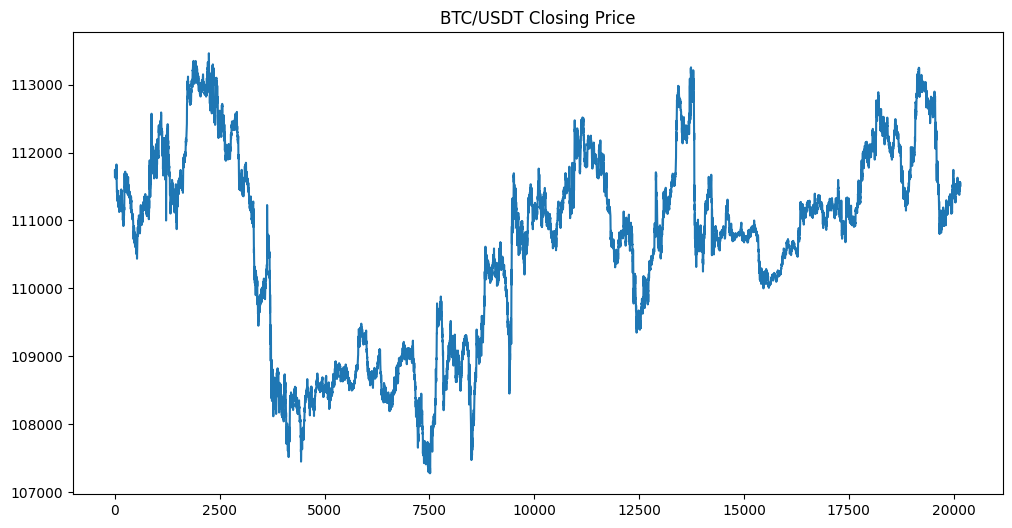

In [4]:
import matplotlib.pyplot as plt

df['close'].plot(figsize=(12,6), title="BTC/USDT Closing Price")
plt.show()


In [5]:
df["returns"] = df["close"].pct_change()
window = 60  # 60 minutes ~ 1 hour rolling window
df["rolling_mean"] = df["returns"].rolling(window).mean()
df["rolling_std"] = df["returns"].rolling(window).std()
df["zscore"] = (df["returns"] - df["rolling_mean"]) / df["rolling_std"]

In [6]:
threshold = 3
df["anomaly_z"] = df["zscore"].apply(lambda x: 1 if abs(x) > threshold else 0)

In [7]:
from sklearn.ensemble import IsolationForest
df_clean = df.dropna()
model = IsolationForest(contamination=0.01, random_state=42)
df_clean["anomaly_if"] = model.fit_predict(df_clean[["returns"]])
df_clean["anomaly_if"] = df_clean["anomaly_if"].apply(lambda x: 1 if x == -1 else 0)


C:\Users\mayan\AppData\Local\Temp\ipykernel_1668\3244323303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["anomaly_if"] = model.fit_predict(df_clean[["returns"]])
C:\Users\mayan\AppData\Local\Temp\ipykernel_1668\3244323303.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["anomaly_if"] = df_clean["anomaly_if"].apply(lambda x: 1 if x == -1 else 0)


In [8]:
# 6. Final anomaly label (supervised target)
# OR rule: anomaly if either method says so
df_clean["anomaly_or"] = df_clean[["anomaly_z", "anomaly_if"]].max(axis=1)

# AND rule: anomaly only if both agree
df_clean["anomaly_and"] = df_clean[["anomaly_z", "anomaly_if"]].min(axis=1)

# choose which one to keep as your final supervised label
df_clean["anomaly"] = df_clean["anomaly_or"]   # or "anomaly_and"

C:\Users\mayan\AppData\Local\Temp\ipykernel_1668\1334102924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["anomaly_or"] = df_clean[["anomaly_z", "anomaly_if"]].max(axis=1)
C:\Users\mayan\AppData\Local\Temp\ipykernel_1668\1334102924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["anomaly_and"] = df_clean[["anomaly_z", "anomaly_if"]].min(axis=1)
C:\Users\mayan\AppData\Local\Temp\ipykernel_1668\1334102924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

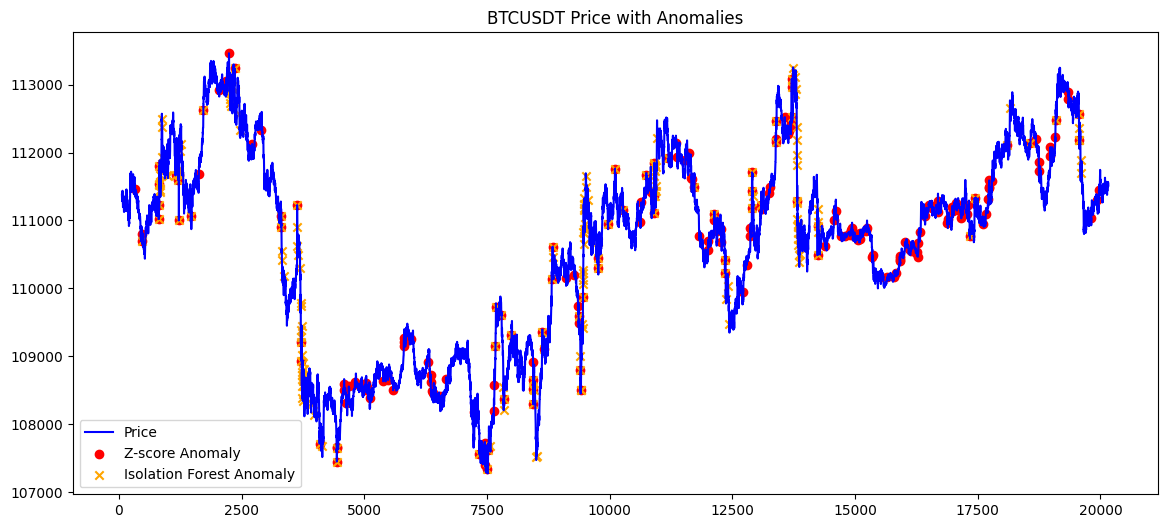

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df_clean.index, df_clean["close"], label="Price", color="blue")

plt.scatter(df_clean.index[df_clean["anomaly_z"]==1],
            df_clean["close"][df_clean["anomaly_z"]==1],
            color="red", label="Z-score Anomaly")

plt.scatter(df_clean.index[df_clean["anomaly_if"]==1],
            df_clean["close"][df_clean["anomaly_if"]==1],
            color="orange", marker="x", label="Isolation Forest Anomaly")

plt.title("BTCUSDT Price with Anomalies")
plt.legend()
plt.show()

In [10]:
df_clean.to_csv("BTCUSDT_with_anomalies.csv")

In [11]:
import pandas as pd

# Load your dataset
df2  = pd.read_csv("BTCUSDT_with_anomalies.csv")

print(df2.head())
df2.info()
df2.describe()
df2['anomaly'].value_counts()


   Unnamed: 0                open_time       open       high        low  \
0          60  1970-01-21 07:50:56.400  111356.38  111400.30  111354.22   
1          61  1970-01-21 07:50:56.460  111379.46  111379.47  111364.61   
2          62  1970-01-21 07:50:56.520  111364.61  111364.62  111326.55   
3          63  1970-01-21 07:50:56.580  111326.56  111326.56  111311.80   
4          64  1970-01-21 07:50:56.640  111311.81  111311.81  111284.17   

       close    volume   returns  rolling_mean  rolling_std    zscore  \
0  111379.47  28.14097  0.000207     -0.000053     0.000339  0.766318   
1  111364.62   9.01967 -0.000133     -0.000049     0.000337 -0.251362   
2  111326.55  12.46312 -0.000342     -0.000046     0.000334 -0.886514   
3  111311.80  10.90521 -0.000132     -0.000053     0.000331 -0.241016   
4  111284.17   8.73125 -0.000248     -0.000055     0.000332 -0.581297   

   anomaly_z  anomaly_if  anomaly_or  anomaly_and  anomaly  
0          0           0           0            0

anomaly
0    19755
1      345
Name: count, dtype: int64

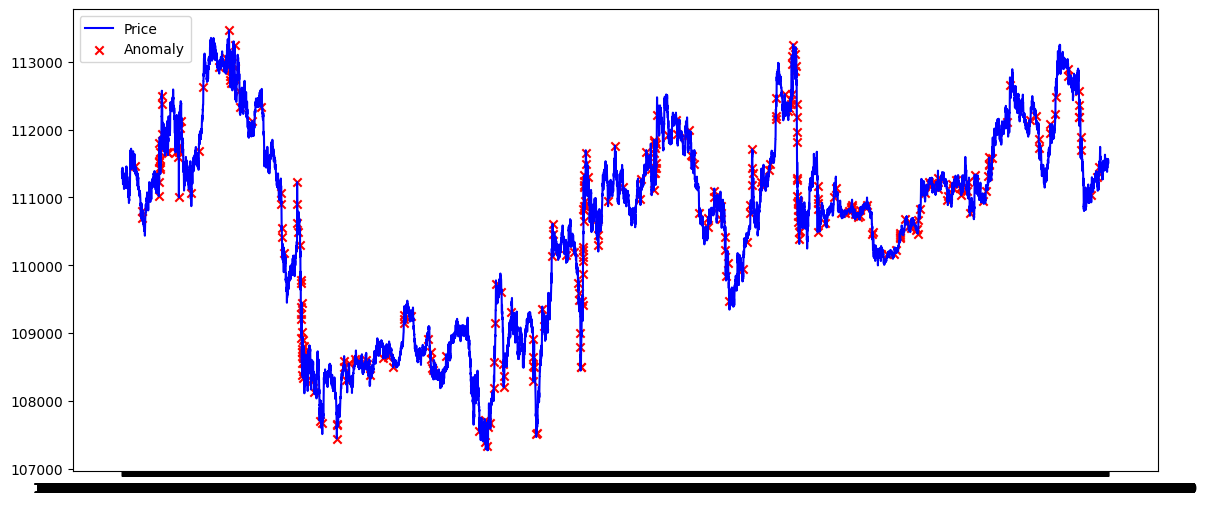

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df2["open_time"], df2["close"], label="Price", color="blue")

anomalies = df2[df2["anomaly"] == 1]
plt.scatter(anomalies["open_time"], anomalies["close"], 
            color="red", label="Anomaly", marker="x")
plt.legend()
plt.show()


In [13]:
ratio = df2["anomaly"].mean() * 100
print(f"Anomaly ratio: {ratio:.2f}%")


Anomaly ratio: 1.72%


In [14]:
df2["returns"] = df2["close"].pct_change()
df2["rolling_mean"] = df2["returns"].rolling(60).mean()  # 1-hour rolling
df2["rolling_std"] = df2["returns"].rolling(60).std()
df2["zscore"] = (df2["returns"] - df2["rolling_mean"]) / df2["rolling_std"]

In [24]:
df2 = df2.dropna()

In [25]:
X = df2[["close", "returns", "rolling_mean", "rolling_std", "zscore"]]
y = df2["anomaly"]  # 0 = normal, 1 = anomaly

In [26]:
split_index = int(len(df2) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [29]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
y_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[3867   89]
 [   0   52]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9775    0.9886      3956
           1     0.3688    1.0000    0.5389        52

    accuracy                         0.9778      4008
   macro avg     0.6844    0.9888    0.7637      4008
weighted avg     0.9918    0.9778    0.9828      4008



In [36]:
import xgboost as xgb

In [37]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [38]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [39]:
y_pred = model.predict(X_test)

In [40]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[3942   14]
 [   5   47]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9965    0.9976      3956
           1     0.7705    0.9038    0.8319        52

    accuracy                         0.9953      4008
   macro avg     0.8846    0.9502    0.9147      4008
weighted avg     0.9958    0.9953    0.9954      4008

